<a href="https://colab.research.google.com/github/anirban-space/pybgp-snn-model/blob/main/PyBGPStream_parse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [4]:
print('Installing dependencies...')
!sudo apt-get install build-essential curl zlib1g-dev libbz2-dev libcurl4-openssl-dev librdkafka-dev
!sudo apt-get update
!sudo apt-get install -y libtool automake autoconf pkg-config
!libtoolize --force
!sudo apt-get install libbz2-dev liblzma-dev liblzo2-dev liblz4-dev libzstd-dev

Installing dependencies...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libbz2-dev is already the newest version (1.0.8-5build1).
libbz2-dev set to manually installed.
curl is already the newest version (7.81.0-1ubuntu1.21).
libcurl4-openssl-dev is already the newest version (7.81.0-1ubuntu1.21).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
The following additional packages will be installed:
  librdkafka++1 librdkafka1
The following NEW packages will be installed:
  librdkafka++1 librdkafka-dev librdkafka1
0 upgraded, 3 newly installed, 0 to remove and 72 not upgraded.
Need to get 1,481 kB of archives.
After this operation, 6,303 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 librdkafka1 amd64 1.8.0-1build1 [633 kB]
Get:2 http://archive.ubuntu.com/ubuntu jamm

In [5]:
print('Installing more build dependencies...')
!sudo apt-get update
!sudo apt-get install -y build-essential autoconf automake libtool curl zlib1g-dev libbz2-dev libcurl4-openssl-dev librdkafka-dev liblzma-dev liblzo2-dev liblz4-dev libzstd-dev libpthread-stubs0-dev
print('Build dependencies installation complete.')

Installing more build dependencies...
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease                         
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                 
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease    
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease          
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree...

In [6]:
%cd /content/

# Cleanup previous attempts for libbgpstream
!rm -rf *

# Create sources
# !mkdir /content/wandio
# !mkdir /content/libbgp
# !mkdir /content/pybgp

wandio_repo = "https://github.com/LibtraceTeam/wandio/archive/refs/tags/4.2.6-1.tar.gz"
libbgpstream_repo = "https://github.com/CAIDA/libbgpstream/releases/download/v2.3.0/libbgpstream-2.3.0.tar.gz"
pybgpstream_repo = "https://github.com/CAIDA/pybgpstream/releases/download/v2.0.4/pybgpstream-2.0.4.tar.gz"

# Download wandio and pybgpstream tarballs
!curl -LO "$wandio_repo"
!curl -LO "$libbgpstream_repo"
!curl -LO "$pybgpstream_repo"

# Clone bgpstream using git clone --recursive
# !git clone --recursive $libbgpstream_repo /content/libbgp

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 16.3M    0 16.3M    0     0  5531k      0 --:--:--  0:00:03 --:--:-- 9050k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.2M  100 11.2M    0     0  8220k      0  0:00:01  0:00:01 --:--:-- 20.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12987  100 12987    0     0  16553      0 --:--:-- --:--:-- --:--:-- 16553


In [7]:
import os

# Get a list of all .tar.gz files in the current directory
tar_files = [f for f in os.listdir('.') if f.endswith('.tar.gz')]

# Extract each tar.gz file individually
for tar_file in tar_files:
    print(f"Extracting {tar_file}...")
    !tar zxf "{tar_file}"


%ls

Extracting libbgpstream-2.3.0.tar.gz...
Extracting 4.2.6-1.tar.gz...
Extracting pybgpstream-2.0.4.tar.gz...
4.2.6-1.tar.gz       libbgpstream-2.3.0.tar.gz  pybgpstream-2.0.4.tar.gz
libbgpstream-2.3.0/  pybgpstream-2.0.4/         wandio-4.2.6-1/


In [8]:
wandio_bootstrap_text = """#! /bin/sh

set +x
# Prefer aclocal 1.9 if we can find it
(which aclocal &> /dev/null && aclocal -I m4) ||
(which aclocal &>/dev/null && aclocal -I m4) ||
	aclocal  -I m4

# Darwin bizarrely uses glibtoolize
(which libtoolize &>/dev/null && libtoolize --force --copy) ||
	glibtoolize --force --copy

(which autoheader &>/dev/null && autoheader) ||
autoheader

# Prefer automake-1.9 if we can find it
(which automake &>/dev/null && automake --add-missing --copy --foreign) ||
	automake --add-missing --copy --foreign

(which autoconf &>/dev/null && autoconf) ||
autoconf"""

bootstrap_command = f"echo '{wandio_bootstrap_text}' > bootstrap.sh"
print(bootstrap_command)

echo '#! /bin/sh

set +x
# Prefer aclocal 1.9 if we can find it
(which aclocal &> /dev/null && aclocal -I m4) ||
(which aclocal &>/dev/null && aclocal -I m4) ||
	aclocal  -I m4

# Darwin bizarrely uses glibtoolize
(which libtoolize &>/dev/null && libtoolize --force --copy) ||
	glibtoolize --force --copy

(which autoheader &>/dev/null && autoheader) ||
autoheader

# Prefer automake-1.9 if we can find it
(which automake &>/dev/null && automake --add-missing --copy --foreign) ||
	automake --add-missing --copy --foreign

(which autoconf &>/dev/null && autoconf) ||
autoconf' > bootstrap.sh


In [9]:
folder_prefixes = ['wandio', 'libbgpstream','pybgpstream']

# wandio_bootstrap_text = """#! /bin/sh

# set +x
# # Prefer aclocal 1.9 if we can find it
# (which aclocal &> /dev/null && aclocal -I m4) ||
# (which aclocal &>/dev/null && aclocal -I m4) ||
# 	aclocal  -I m4

# # Darwin bizarrely uses glibtoolize
# (which libtoolize &>/dev/null && libtoolize --force --copy) ||
# 	glibtoolize --force --copy

# (which autoheader &>/dev/null && autoheader) ||
# autoheader

# # Prefer automake-1.9 if we can find it
# (which automake &>/dev/null && automake --add-missing --copy --foreign) ||
# 	automake --add-missing --copy --foreign

# (which autoconf &>/dev/null && autoconf) ||
# autoconf"""

# bootstrap_command = f"echo '{wandio_bootstrap_text}' > bootstrap.sh"

# Define a dictionary mapping each prefix to a list of commands to execute within that directory.
prefix_commands = {
    'wandio': [
        bootstrap_command,
        './bootstrap.sh',
        'chmod a+X configure',
        './configure',
        'make',
        'sudo make install',
        'sudo ldconfig'
    ],
    'libbgpstream': [
        './autogen.sh', # Run autogen.sh first to prepare build files, now that it's a git repo
        'chmod a+X configure',
        './configure',
        'make',
        'make check',
        'sudo make install',
        'sudo ldconfig'
    ],
    'pybgpstream': [
        'python setup.py build_ext',
        'python setup.py build',
        'python setup.py install'
    ]
}

print(f"Defined folder prefixes: {folder_prefixes}")
print(f"Defined commands for prefixes: {prefix_commands}")

Defined folder prefixes: ['wandio', 'libbgpstream', 'pybgpstream']
Defined commands for prefixes: {'wandio': ["echo '#! /bin/sh\n\nset +x\n# Prefer aclocal 1.9 if we can find it\n(which aclocal &> /dev/null && aclocal -I m4) ||\n(which aclocal &>/dev/null && aclocal -I m4) ||\n\taclocal  -I m4\n\n# Darwin bizarrely uses glibtoolize\n(which libtoolize &>/dev/null && libtoolize --force --copy) ||\n\tglibtoolize --force --copy\n\n(which autoheader &>/dev/null && autoheader) ||\nautoheader\n\n# Prefer automake-1.9 if we can find it\n(which automake &>/dev/null && automake --add-missing --copy --foreign) ||\n\tautomake --add-missing --copy --foreign\n\n(which autoconf &>/dev/null && autoconf) ||\nautoconf' > bootstrap.sh", './bootstrap.sh', 'chmod a+X configure', './configure', 'make', 'sudo make install', 'sudo ldconfig'], 'libbgpstream': ['./autogen.sh', 'chmod a+X configure', './configure', 'make', 'make check', 'sudo make install', 'sudo ldconfig'], 'pybgpstream': ['python setup.py buil

In [10]:
!ls

4.2.6-1.tar.gz	    libbgpstream-2.3.0.tar.gz  pybgpstream-2.0.4.tar.gz
libbgpstream-2.3.0  pybgpstream-2.0.4	       wandio-4.2.6-1


In [11]:
import os
import glob

# Ensure folder_prefixes and prefix_commands are available from the previous cell.
# If not defined, initialize them to empty structures to prevent errors.
if 'folder_prefixes' not in globals():
    folder_prefixes = []
if 'prefix_commands' not in globals():
    prefix_commands = {}

# Store the original working directory to return to if needed, or to navigate from /content/
original_cwd = os.getcwd()

print(f"Processing a total of {len(folder_prefixes)} prefixes: {folder_prefixes}")

for prefix in folder_prefixes:
    print(f"\n--- Processing prefix: {prefix} ---")
    search_pattern = f'{prefix}*/'

    # Go back to the base content directory to search for top-level folders
    %cd /content/

    list_of_directories = [d for d in glob.glob(search_pattern) if os.path.isdir(d)]

    extracted_folder = None
    if list_of_directories:
        # Sort directories by modification time in descending order to get the latest.
        list_of_directories.sort(key=os.path.getmtime, reverse=True)
        extracted_folder = list_of_directories[0].strip('/')

        print(f"Found latest directory for '{prefix}': {extracted_folder}")
        print(f"Changing directory to: {extracted_folder}")
        # Use %cd magic command to change the notebook's working directory.
        %cd "$extracted_folder"

        # Execute commands for the current prefix
        if prefix in prefix_commands:
            commands_to_execute = prefix_commands[prefix]
            if commands_to_execute:
                print(f"Executing {len(commands_to_execute)} commands for {prefix}:")
                for command in commands_to_execute:
                    print(f"  Executing command: {command}")
                    # Execute the command. Using ! for shell commands.
                    !{command}
            else:
                print(f"No commands defined for prefix '{prefix}' in prefix_commands.")
        else:
            print(f"Prefix '{prefix}' not found in prefix_commands. No commands to execute.")
    else:
        print(f"No directories found matching '{search_pattern}' for prefix '{prefix}'. Skipping commands for this prefix.")

print("\n--- All prefixes processed. ---")
# Optionally, return to the original working directory or /content/
%cd /content/

Processing a total of 3 prefixes: ['wandio', 'libbgpstream', 'pybgpstream']

--- Processing prefix: wandio ---
/content
Found latest directory for 'wandio': wandio-4.2.6-1
Changing directory to: wandio-4.2.6-1
/content/wandio-4.2.6-1
Executing 7 commands for wandio:
  Executing command: echo '#! /bin/sh

set +x
# Prefer aclocal 1.9 if we can find it
(which aclocal &> /dev/null && aclocal -I m4) ||
(which aclocal &>/dev/null && aclocal -I m4) ||
	aclocal  -I m4

# Darwin bizarrely uses glibtoolize
(which libtoolize &>/dev/null && libtoolize --force --copy) ||
	glibtoolize --force --copy

(which autoheader &>/dev/null && autoheader) ||
autoheader

# Prefer automake-1.9 if we can find it
(which automake &>/dev/null && automake --add-missing --copy --foreign) ||
	automake --add-missing --copy --foreign

(which autoconf &>/dev/null && autoconf) ||
autoconf' > bootstrap.sh
  Executing command: ./bootstrap.sh
/usr/bin/aclocal
/usr/bin/libtoolize
libtoolize: putting auxiliary files in '.'.
lib

In [12]:
# colab_home = "/home/anirban"
# wandio_src = colab_home+"/wandio-src/wandio-4.2.4-1/"
# libbgp_src = colab_home+"/libbgp-src/libbgpstream-2.3.0/"
# pybgp_src = colab_home+"/pybgpstream-src/pybgpstream-2.0.4"
# %cd $wandio_src
# %ls
# !sudo ./bootstrap.sh
# !sudo chmod a+X configure
# !sudo ./configure
# !make
# !make install
# !sudo ldconfig

In [13]:
# %cd $libbgp_src
# %ls
# !sudo ./configure
# !./install-sh
# !make
# !make check
# !make install
# !sudo ldconfig

In [14]:
# %cd $pybgp_src
# %ls
# !python setup.py build_ext
# !python setup.py build
# !python setup.py install

In [15]:
!curl https://raw.githubusercontent.com/CAIDA/pybgpstream/master/examples/tutorial_print.py | python

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2252  100  2252    0     0   5089      0 --:--:-- --:--:-- --:--:--  5095
valid ris.rrc06 1427846570.0
	 W 202.249.2.185 25152 W {'prefix': '144.104.37.0/24'}
valid ris.rrc06 1427846573.0
	 A 2001:200:0:fe00::6249:0 25152 A {'next-hop': '2001:200:0:fe00::9c1:0', 'as-path': '25152 2497 6939 47541 28709', 'communities': set(), 'prefix': '2a00:bdc0:e004::/48'}
valid ris.rrc06 1427846573.0
	 A 202.249.2.185 25152 A {'next-hop': '202.249.2.185', 'as-path': '25152 6939 22059', 'communities': set(), 'prefix': '64.34.125.0/24'}
	 A 202.249.2.185 25152 A {'next-hop': '202.249.2.185', 'as-path': '25152 6939 22059', 'communities': set(), 'prefix': '76.191.107.0/24'}
valid ris.rrc06 1427846573.0
	 A 2001:200:0:fe00::6249:0 25152 A {'next-hop': '2001:200:0:fe00::6249:0', 'as-path': '25152 6939 47541 28709', 'communities': set(), 'prefix':

In [16]:
#Verify installation from lib folder
!ls /usr/local/lib

cmake				     libomptarget.sycl.wrap.so
julia				     libonedal_core.so.3
libarcher.so			     libonedal_dpc.so.3
libarcher_static.a		     libonedal_parameters_dpc.so.3
libbgpstream.a			     libonedal_parameters.so.3
libbgpstream.la			     libonedal.so.3
libbgpstream.so			     libonedal_thread.so.3
libbgpstream.so.4		     libparsebgp.a
libbgpstream.so.4.0.0		     libparsebgp.la
libhwloc.so			     libparsebgp.so
libhwloc.so.15			     libparsebgp.so.2
libhwloc.so.15.8.1		     libparsebgp.so.2.0.0
libiomp5.a			     libtbbbind_2_0.so
libiomp5.dbg			     libtbbbind_2_0.so.3
libiomp5_db.so			     libtbbbind_2_0.so.3.17
libiomp5.so			     libtbbbind_2_5.so
libiompstubs5.a			     libtbbbind_2_5.so.3
libiompstubs5.so		     libtbbbind_2_5.so.3.17
libjulia.so			     libtbbbind.so
libjulia.so.1.11		     libtbbbind.so.3
libjulia.so.1.11.5		     libtbbbind.so.3.17
libmkl_avx2.so.2		     libtbbmalloc_proxy.so
libmkl_avx512.so.2		     libtbbmalloc_proxy.so.2
libmkl_blacs_intelmpi_ilp64.so.2     libtbbm

In [17]:
!which python3
import sys
print(sys.path)

import os
import sys

# Add the directory where 'pybgpstream' folder is located
# If you installed from source to /usr/local/lib/python3.10/dist-packages (default):
sys.path.append("/usr/local/lib/python3.12/dist-packages")

# If you installed it into your custom Drive home:
sys.path.append('/content/')

# Update LD_LIBRARY_PATH for the current Python process
os.environ['LD_LIBRARY_PATH'] = "/usr/local/lib:" + os.environ.get('LD_LIBRARY_PATH', '')



/usr/bin/python3
['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
# This is kill switch. Need to run next cell manually. It's same as "Runtime > Restart Session"
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [1]:
import pybgpstream
print("Success!")


Success!


In [2]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org brian2

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/pybgpstream-2.0.4-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.1 MB/s eta 0:00:00a 0:00:01


In [ ]:
import pybgpstream
import numpy as np
from datetime import datetime
import time

# --- CONFIGURATION ---
GLOBAL_START = "2008-02-24 18:40:00"
GLOBAL_END   = "2008-02-24 21:05:00"
TARGET_ASN   = 17557
OUTPUT_FILE  = "bgp_spikes_2008_hijack.npz"

global_start_dt = datetime.strptime(GLOBAL_START, "%Y-%m-%d %H:%M:%S")

def fetch_prep_and_save():
    print("PHASE 1: Fetching BGP data from RRC00...")
    start_cpu = time.time()
    
    stream = pybgpstream.BGPStream(
        from_time=GLOBAL_START,
        until_time=GLOBAL_END,
        collectors=['rrc00'],
        record_type="updates"
    )
    
    indices = []
    times = []
    
    for elem in stream:
        ts = elem.time
        abs_ms = (ts - global_start_dt.timestamp()) * 1000.0
        try:
            path = elem.fields.get('as-path', '')
            origin = path.split(' ')[-1].strip('{}').split(',')[0]
        except: continue
        
        if str(origin) == str(TARGET_ASN):
            indices.append(1)
        else:
            indices.append(0)
        times.append(abs_ms)

    print(f"Loaded {len(times)} updates. Converting to RAM arrays...")
    indices = np.array(indices, dtype=np.int32)
    times = np.array(times, dtype=np.float64)
    
    # Fast Sorting
    print("Sorting...")
    sort_idx = np.argsort(times)
    indices = indices[sort_idx]
    times = times[sort_idx]
    
    # Micro-Jittering (The CPU intensive part)
    print("Applying micro-jitter to prevent Brian2 collisions...")
    dt_val = 0.1 
    for i in range(1, len(times)):
        if times[i] <= times[i-1]:
            times[i] = times[i-1] + dt_val

    # Save to disk as compressed binary
    print(f"Saving to {OUTPUT_FILE}...")
    np.savez_compressed(OUTPUT_FILE, indices=indices, times=times)
    
    print(f"Data Prep Complete in {time.time() - start_cpu:.2f} seconds.")

if __name__ == "__main__":
    fetch_prep_and_save()

In [3]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time


# ==========================================
# 0. JUPYTER / C++ MEMORY RESET (The Fix)
# ==========================================
start_scope()    # Tells Brian2 to forget all previous "ghost" objects
device.reinit()  # Resets the C++ standalone compiler state

# ==========================================
# 1. C++ STANDALONE MODE (Maximum CPU Speed)
# ==========================================
set_device('cpp_standalone', directory='SNN_build', build_on_run=True)

# --- CONFIGURATION ---
INPUT_FILE   = "bgp_spikes_2008_hijack.npz"
GLOBAL_START = "2008-02-24 18:40:00"
SIM_DT       = 0.1 * ms 
TAU_REC      = 120 * ms   
COST_PER_SPIKE = 0.45     

defaultclock.dt = SIM_DT
global_start_dt = datetime.strptime(GLOBAL_START, "%Y-%m-%d %H:%M:%S")

# ==========================================
# 2. LOAD DATA DIRECTLY TO RAM
# ==========================================
print(f"Loading pre-processed spikes from {INPUT_FILE}...")
load_start = time.time()

# np.load pulls the binary file straight into C-contiguous RAM arrays
data = np.load(INPUT_FILE)
all_indices = data['indices']
all_times = data['times']

print(f"Loaded {len(all_times)} spikes into RAM in {time.time() - load_start:.3f} seconds.")

# ==========================================
# 3. BUILD & RUN SNN
# ==========================================
print("\nBuilding the Neural Network...")

# We create the SpikeGeneratorGroup and give all data.
Peers = SpikeGeneratorGroup(2, all_indices, all_times * ms) 
# With D
# Target = NeuronGroup(1, 'dv/dt = -v/(10*ms) : 1', threshold='v>1', reset='v=0')
# Without D
Target = NeuronGroup(1, 'dv/dt = -v/(10*ms) : 1', threshold='v>1', reset='v=0', method='exact')

# With D
# syn_eqs = '''
# w : 1
# dD/dt = (1-D)/tau_rec : 1 (clock-driven)
# dApre/dt = -Apre/(20*ms) : 1 (event-driven)
# dApost/dt = -Apost/(20*ms) : 1 (event-driven)
# U : 1
# tau_rec : second
# '''

# on_pre_logic = '''
# D = clip(D * (1 - U), 0, 1)     
# v_post += w * D                 
# Apre += 0.01
# w = clip(w + Apost, 0, 1)
# '''

# on_post_logic = '''
# Apost -= 0.012
# w = clip(w + Apre, 0, 1)
# '''

syn_eqs = '''w : 1
                dApre/dt = -Apre/(20*ms) : 1 (event-driven)
                dApost/dt = -Apost/(20*ms) : 1 (event-driven)'''

on_pre_logic = '''v_post += w
                      Apre += 0.01
                      w = clip(w + Apost, 0, 1)'''

on_post_logic = '''Apost -= 0.012
                      w = clip(w + Apre, 0, 1)'''

S = Synapses(Peers, Target, model=syn_eqs, on_pre=on_pre_logic, on_post=on_post_logic)
S.connect(i=[0, 1], j=[0, 0])

S.w = 0.5          

# S.D = 1.0          
# S.U = COST_PER_SPIKE 
# S.tau_rec = TAU_REC 

# w_mon = StateMonitor(S, ['w', 'D'], record=True, dt=1*second) 

# net = Network(Peers, Target, S) # explicitly manage the network object
w_mon = StateMonitor(S, 'w', record=[0,1], dt=1*second)
# net.add(w_mon)

duration = (all_times[-1] + 100) * ms
print(f"Simulating {duration} of network time in C++...")
start_sim = time.time()

run(duration) 

print(f"Simulation Complete in {time.time() - start_sim:.2f} seconds.")

Loading pre-processed spikes from bgp_spikes_2008_hijack.npz...
Loaded 133886 spikes into RAM in 0.010 seconds.

Building the Neural Network...
Simulating 8.7001017 ks of network time in C++...
Simulation Complete in 25.51 seconds.


In [ ]:
# 1. Fix the interrupted dpkg process
# !dpkg --configure -a

# 2. Clean up any broken dependencies
# !apt-get install -f

# Force-fix the locked system
# !rm -f /var/lib/dpkg/lock-frontend
# !dpkg --configure -a
# !apt-get install -f -y

# Install only the bare essentials
# !DEBIAN_FRONTEND=noninteractive apt-get install -y texlive-latex-extra dvipng cm-super > /dev/null

# 3. (Optional) Clear the "sources" warning by updating
# !apt-get update
# !DEBIAN_FRONTEND=noninteractive apt-get install -y texlive-full texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Setting up context (2021.03.05.20220211-1) ...
Running mtxrun --generate. This may take some time... done.
Pregenerating ConTeXt MarkIV format. This may take some time... 

In [ ]:
import matplotlib.pyplot as plt

# 1. Clear any stuck settings
plt.rcdefaults()

# 2. Configure for "LaTeX-style" without using an external compiler
plt.rcParams.update({
    "text.usetex": False,            # Disable the external 'pdflatex' call
    "font.family": "serif",          # Use serif fonts
    "mathtext.fontset": "cm",        # Force Computer Modern for math
    "font.serif": ["Computer Modern Roman"],
    "axes.formatter.use_mathtext": True # Use mathtext for axis numbers
})

# 3. Plotting
plt.figure(figsize=(8, 5))
plt.plot([0, 1, 2], [0, 1, 4], 'r-o', label=r'$y = x^2$')

# You can still use LaTeX syntax in labels!
plt.xlabel(r'Time ($t_{seconds}$)', fontsize=12)
plt.ylabel(r'Amplitude ($\Phi$)', fontsize=12)
plt.title(r'Pseudo-LaTeX Rendering: $\frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [11]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org pdflatex

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/pybgpstream-2.0.4-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
^C
ERROR: Operation cancelled by user


In [8]:
import matplotlib.pyplot as plt

# This wipes all custom rcParams and goes back to standard settings
plt.rcdefaults()


Plotting Results...


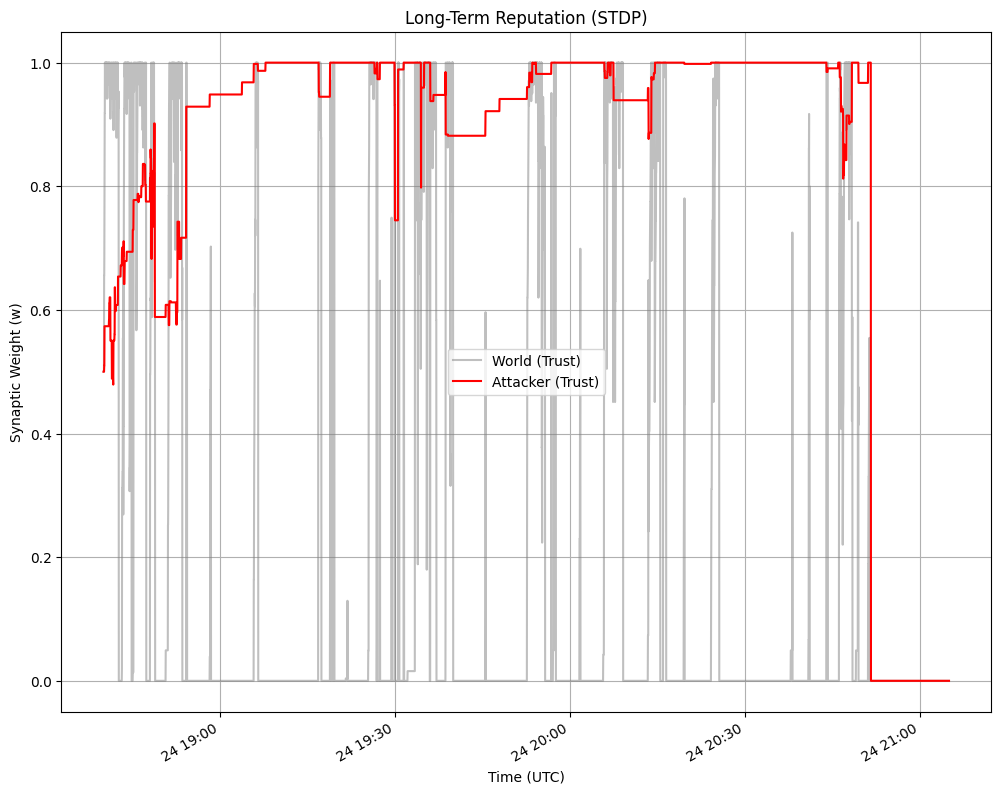

In [9]:
# ==========================================
# 4. PLOTTING
# ==========================================
print("\nPlotting Results...")
utc_times = [global_start_dt + timedelta(seconds=float(t)) for t in w_mon.t]

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 10), sharex=True)

ax1.plot(utc_times, w_mon.w[0], label='World (Trust)', color='grey', alpha=0.5)
ax1.plot(utc_times, w_mon.w[1], label='Attacker (Trust)', color='red')
ax1.set_ylabel('Synaptic Weight (w)')
ax1.set_title('Long-Term Reputation (STDP)')
ax1.legend()
ax1.grid(True)

# ax2.plot(utc_times, w_mon.D[0], label='World Resources (D)', color='grey', alpha=0.5)
# ax2.plot(utc_times, w_mon.D[1], label='Attacker Resources (D)', color='red')
# ax2.set_ylabel('Synaptic Resources (D)')
# ax2.set_title(f'Leaky Trust Dynamics (U={COST_PER_SPIKE}, Tau={TAU_REC/ms}ms)')
# ax2.set_ylim(0, 1.1)
# ax2.legend()
# ax2.grid(True)
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Try saving in latex format
# Latex Part
# Set the backend to pgf
# plt.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     "font.family": "serif",  # Match LaTeX default
#     "text.usetex": True,     # Use LaTeX to render text
#     "pgf.rcfonts": False,    # Don't use matplotlib's font settings
# })

plt.xlabel('Time (UTC)')
plt.gcf().autofmt_xdate()

# Save as .pgf
# plt.savefig("my_plot.pgf")

plt.show()

In [ ]:
#!cp -r /home/anirban /content/drive/MyDrive/ColabHomeBackup/PyBGPColab/

In [ ]:
import os, sys
# os.environ['PYTHONPATH'] += ":/content/drive/MyDrive/ColabHomeBackup/PyBGPColab/anirban"
# If your library is directly in the new_home folder:
# sys.path.append("/content/drive/MyDrive/ColabHomeBackup/PyBGPColab/anirban")